### MDN References:

[useful pytorch reference](https://github.com/tonyduan/mixture-density-network)

[keras version](https://github.com/cpmpercussion/keras-mdn-layer)

[another keras version](https://github.com/omimo/Keras-MDN/blob/master/kmdn/mdn.py)


In [1]:
import MDN
import numpy as np
import tensorflow as tf
import tensorflow.keras.backend as K
import pandas as pd
from ProcessTrueStateActionData import read_df_in_chunks

from true_state_viewer import TrueStateTreeGraphViz, display_tree_red_preds

import time
from IPython import display
from pathlib import Path

### Load and preprocess the data 
(produce tf train+test datasets)

In [2]:
batch_size = 128
train_test_split = 0.999

LATENT_SIZE = 8 # (mdn output_dimension)
NUMBER_MIXTURES = 5

EPOCHS = 50

# DATA_CAP = 3_000_000

/usr/local/lib/python3.8/dist-packages/ipykernel/ipkernel.py:281: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [32]:
def get_columns_for_training():
    true_states = ["pre","blue","red", "_"]
    ts_columns = {}
    for true_state in true_states:
        ts_columns[true_state] = []
        for node in range(13):
            ts_columns[true_state].append(f"{node}_ts_{true_state}_known_status")
            ts_columns[true_state].append(f"{node}_ts_{true_state}_access_status")
    return ts_columns

In [33]:
cols_dict = get_columns_for_training()
pre_cols, blue_cols, red_cols = cols_dict["pre"], cols_dict["blue"], cols_dict["red"]
all_cols = pre_cols + blue_cols + red_cols

In [5]:
def pre_process_chunk(full_df, chunk_df, all_cols):
    chunk_df = chunk_df[all_cols].astype("category")
    full_df = pd.concat([full_df, chunk_df])
    return full_df

In [6]:
chunks_data_path = "csv_data/TrueStatesObsActsRwds_1221_4000_B_Line_chunks_500000"

full_df = pd.DataFrame(columns=all_cols)

pathlist = Path(chunks_data_path).glob('**/*.parquet')
for path in pathlist:
    # because path is object not string
    print(f"loading chunk: {path}")
    chunk_df = pd.read_parquet(path)
    full_df = pre_process_chunk(full_df, chunk_df, all_cols)
    
df = full_df

loading chunk: csv_data/TrueStatesObsActsRwds_1221_4000_B_Line_chunks_500000/chunk_8.parquet
loading chunk: csv_data/TrueStatesObsActsRwds_1221_4000_B_Line_chunks_500000/chunk_5.parquet
loading chunk: csv_data/TrueStatesObsActsRwds_1221_4000_B_Line_chunks_500000/chunk_2.parquet
loading chunk: csv_data/TrueStatesObsActsRwds_1221_4000_B_Line_chunks_500000/chunk_7.parquet
loading chunk: csv_data/TrueStatesObsActsRwds_1221_4000_B_Line_chunks_500000/chunk_9.parquet
loading chunk: csv_data/TrueStatesObsActsRwds_1221_4000_B_Line_chunks_500000/chunk_6.parquet
loading chunk: csv_data/TrueStatesObsActsRwds_1221_4000_B_Line_chunks_500000/chunk_3.parquet
loading chunk: csv_data/TrueStatesObsActsRwds_1221_4000_B_Line_chunks_500000/chunk_1.parquet
loading chunk: csv_data/TrueStatesObsActsRwds_1221_4000_B_Line_chunks_500000/chunk_0.parquet
loading chunk: csv_data/TrueStatesObsActsRwds_1221_4000_B_Line_chunks_500000/chunk_4.parquet


In [5]:
# df=pd.read_parquet("csv_data/TrueStatesObsActsRwds_1221_4000_B_Line.parquet").iloc[:DATA_CAP]
# df = df[all_cols].astype("category")

In [7]:
print(len(full_df))
df.memory_usage(deep=True)

4884000


/usr/local/lib/python3.8/dist-packages/ipykernel/ipkernel.py:281: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Index                      39072000
0_ts_pre_known_status       4884124
0_ts_pre_access_status      4884116
1_ts_pre_known_status       4884132
1_ts_pre_access_status      4884132
                             ...   
10_ts_red_access_status     4884132
11_ts_red_known_status      4884124
11_ts_red_access_status     4884132
12_ts_red_known_status      4884124
12_ts_red_access_status     4884132
Length: 79, dtype: int64

In [8]:
train_df=df.sample(frac=train_test_split,random_state=42)
train_pre_df = train_df[pre_cols]
train_blue_df = train_df[blue_cols]
train_red_df = train_df[red_cols]

test_df=df.drop(train_df.index)
test_pre_df = test_df[pre_cols]
test_blue_df = test_df[blue_cols]
test_red_df = test_df[red_cols]

train_size = train_df.shape[0]
test_size = test_df.shape[0]

/usr/local/lib/python3.8/dist-packages/ipykernel/ipkernel.py:281: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [9]:
print(train_size)

4879116


/usr/local/lib/python3.8/dist-packages/ipykernel/ipkernel.py:281: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [10]:
train_dataset = (tf.data.Dataset.from_tensor_slices(((train_pre_df.values,train_blue_df.values),train_red_df.values)).batch(batch_size))
test_dataset = (tf.data.Dataset.from_tensor_slices(((test_pre_df.values,test_blue_df.values),test_red_df.values)).batch(1))

In [11]:
for row in train_dataset.take(1):
  print(row)

((<tf.Tensor: shape=(128, 26), dtype=int64, numpy=
array([[0, 0, 2, ..., 0, 2, 2],
       [0, 0, 0, ..., 0, 1, 0],
       [0, 0, 2, ..., 2, 1, 0],
       ...,
       [1, 0, 1, ..., 0, 1, 0],
       [1, 0, 1, ..., 0, 1, 0],
       [0, 0, 0, ..., 0, 1, 0]])>, <tf.Tensor: shape=(128, 26), dtype=int64, numpy=
array([[0, 0, 2, ..., 0, 2, 2],
       [0, 0, 0, ..., 0, 1, 0],
       [0, 0, 2, ..., 2, 1, 0],
       ...,
       [1, 0, 1, ..., 0, 1, 0],
       [1, 0, 1, ..., 0, 1, 0],
       [0, 0, 0, ..., 0, 1, 0]])>), <tf.Tensor: shape=(128, 26), dtype=int64, numpy=
array([[0, 0, 2, ..., 0, 2, 2],
       [0, 0, 0, ..., 0, 1, 0],
       [0, 0, 2, ..., 2, 1, 0],
       ...,
       [1, 0, 1, ..., 0, 1, 0],
       [1, 0, 1, ..., 0, 1, 0],
       [0, 0, 0, ..., 0, 1, 0]])>)


### Create an MDN based model with pretrained encoder/decoder layers

In [12]:
class RedTSPrediction(tf.keras.Model):

    def __init__(self, vae_path, latent_size, num_mixtures):
        super().__init__()
        self.ts_vae = tf.keras.models.load_model(vae_path)
        self.ts_vae.trainable = False
        self.encoder = self.ts_vae.encoder
        self.decoder = self.ts_vae.decoder

        self.ts_dense = tf.keras.layers.Dense(1024, activation=tf.nn.relu)
        self.cross_dense = tf.keras.layers.Dense(4096, activation=tf.nn.relu)
        
        self.fc_1 = tf.keras.layers.Dense(4096, activation=tf.nn.relu)

        self.mdn = MDN.MDN(output_dimension=latent_size, num_mixtures=num_mixtures)

    @tf.function(input_signature=[tf.TensorSpec(shape=[None,78], dtype=tf.float32)])
    def encode(self, x):
        mean, logvar = tf.split(self.encoder(x), num_or_size_splits=2, axis=1)
        z = self.reparameterize(mean, logvar)
        return z
    
    @tf.function(input_signature=[tf.TensorSpec(shape=[None,LATENT_SIZE], dtype=tf.float32),tf.TensorSpec(shape=[None,LATENT_SIZE], dtype=tf.float32)])
    def reparameterize(self, mean, logvar):
        #     eps = tf.random.normal(shape=mean.shape)
        eps = tf.random.normal(shape=tf.shape(mean))

        return eps * tf.exp(logvar * .5) + mean
 
    @tf.function(input_signature=[tf.TensorSpec(shape=[None,LATENT_SIZE], dtype=tf.float32)])
    def decode(self, latent, apply_sigmoid=False):
        logits = self.decoder(latent)
        if apply_sigmoid:
          probs = tf.sigmoid(logits)
        return logits #self.decoder(latent_pred)

    @tf.function#(input_signature=[tf.TensorSpec(shape=[None,26], dtype=tf.uint8),tf.TensorSpec(shape=[None,26], dtype=tf.uint8)])
    def call(self, inputs):
        pre_ts = inputs[0]
        blue_ts = inputs[1]
        
        pre_ts_oh = tf.cast(tf.reshape(tf.one_hot(pre_ts,3),(-1,78)),tf.float32)
#         pre_ts_access = tf.reshape(tf.one_hot(pre_ts[:,13:],3),(-1,39))
        
        blue_ts_oh = tf.cast(tf.reshape(tf.one_hot(blue_ts,3),(-1,78)),tf.float32)
#         blue_ts_access = tf.reshape(tf.one_hot(blue_ts[:,13:],3),(-1,39))
        
#         print(pre_ts[:,:])
#         print(pre_ts_oh)
#         print(blue_ts)
#         blue_ts_kn = K.print_tensor(blue_ts[:,:13], message='blue known = ')
#         blue_ts_known = K.print_tensor(blue_ts_known[:,:13], message='blue known OH = ')
#         print(blue_ts_known.shape)

        pre_ts_encoded = self.encode(pre_ts_oh)
#         mean, logvar = self.ts_vae.encode(pre_ts_oh)
#         mean, logvar = tf.split(self.encoder(pre_ts_oh), num_or_size_splits=2, axis=1)
#         pre_ts_encoded = self.reparameterize(mean, logvar)
        pre_ts_encoded = self.ts_dense(pre_ts_encoded)
        
        blue_ts_encoded = self.encode(blue_ts_oh)
        blue_ts_encoded = self.ts_dense(blue_ts_encoded)

        combined = tf.keras.layers.concatenate([pre_ts_encoded, blue_ts_encoded])

        combined_hidden = self.cross_dense(combined)
        
        fc = self.fc_1(combined_hidden)

        mdn_out = self.mdn(fc)

        return mdn_out
        


In [13]:
@tf.function
def forward_pass(model, x, y):
    out = model(x)
    
    y_oh = tf.reshape(tf.one_hot(y,3),(-1,78))
    y_encoded = model.encode(y_oh)
    
    return out, y_encoded

@tf.function
def decode_z(model, x):
    x_oh = model.ts_vae.get_oh_output(model.decode(tf.cast(x,tf.float32)))
#     y_oh = model.ts_vae.get_oh_output(model.decode(tf.cast(y,tf.float32)))
    
    return x_oh
    

@tf.function
def compute_loss(model, x, y, loss_func):
    out, y_encoded = forward_pass(model, x, y)
    
    loss = loss_func(y_encoded, out)
    
    return loss
    

@tf.function
def train_step(model, x, y, optimizer, loss_func):
    """Executes one training step and returns the loss.

    This function computes the loss and gradients, and uses the latter to
    update the model's parameters.
    """
#     y_encoded = model.encode(y)
    with tf.GradientTape() as tape:
        loss = compute_loss(model, x, y, loss_func)
    gradients = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))

### Training loop

In [14]:
red_ts_predictor = RedTSPrediction('models/trueStateVAE_7_L8', latent_size=LATENT_SIZE, num_mixtures=NUMBER_MIXTURES)

In [16]:
for row in test_dataset.take(1):
#   print(row)
  out = red_ts_predictor(row[0])
  print(out)

tf.Tensor(
[[-0.12222395  0.01585624  0.00727669  0.02337963 -0.10568135 -0.03288135
  -0.02218098  0.11942726 -0.0305853  -0.07263276  0.02637395  0.07172744
  -0.01315062  0.03927666  0.04185179 -0.02946183 -0.02907011 -0.02483988
   0.12993863  0.0746675  -0.02883039 -0.07881409 -0.04964251  0.01882863
   0.09136044  0.04786986 -0.02841164 -0.08794334 -0.03244712 -0.01360381
  -0.07149517 -0.01682883 -0.04962696  0.02391597  0.1142946  -0.02050039
  -0.1108646  -0.05139026  0.06124741  0.03488232  0.98607945  1.1665311
   0.9712365   0.9638739   1.0037962   1.0348972   0.91646785  0.8797206
   0.9665289   0.9335194   0.98988116  1.0152488   0.9687118   1.0680681
   1.0253307   1.0036045   1.0672158   0.9280012   0.95186555  0.99818397
   0.94740385  1.0470762   1.0349078   1.0047235   0.9779146   1.0252663
   0.9368207   0.94395226  0.98524207  0.8728518   0.98289025  1.0881991
   0.96212095  1.0134054   1.1228137   1.0559785   0.90827733  1.0187753
   1.0885262   0.96832    -0.1140

In [17]:
# red_ts_predictor.compile(loss=get_mixture_loss_func(LATENT_SIZE,NUMBER_MIXTURES,red_ts_predictor.encode), optimizer=tf.keras.optimizers.Adam(),metrics=['mean_squared_error'])
# red_ts_predictor.build(((1,78),(1,78)))
red_ts_predictor.summary()


Model: "red_ts_prediction"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 true_state_vae_4 (TrueState  multiple                 121736094 
 VAE)                                                            
                                                                 
 sequential_8 (Sequential)   (None, 16)                60892016  
                                                                 
 sequential_9 (Sequential)   (None, 78)                60844078  
                                                                 
 dense (Dense)               multiple                  9216      
                                                                 
 dense_1 (Dense)             multiple                  8392704   
                                                                 
 dense_2 (Dense)             multiple                  16781312  
                                                 

In [18]:
loss_func = MDN.get_mixture_loss_func(LATENT_SIZE,NUMBER_MIXTURES)
optimizer = tf.keras.optimizers.Adam(1e-4)

In [19]:
# train_dataset=test_dataset.take(10)

# EPOCHS = 500
for epoch in range(1, EPOCHS + 1):
    count = 0
    start_time = time.time()
    for train_x, train_y in train_dataset:
        if (count %1000) == 0:
            print(f"{count}={count*batch_size} samples")
        train_step(red_ts_predictor, train_x, train_y, optimizer, loss_func)
        count += 1
    end_time = time.time()

    
    total_matches = 0
    total = 0
    nodes = 0
    sum_diffs_sqrd = 0
    state_pred_pairs = []
    state_pred_pair_tree_vis = []
    loss = tf.keras.metrics.Mean()
    for test_x, test_y in test_dataset.take(1000):#.take(10):#test_dataset:
        total += 1
        if (total %100) == 0:
            print(f"{total}={total*1} samples")
        out, y_encoded = forward_pass(red_ts_predictor, test_x, test_y)
        loss_val = loss_func(y_encoded, out)
        loss(loss_val)
        
#         sampled_out = MDN.sample_from_output(out[0].numpy(), output_dim=LATENT_SIZE, num_mixes=NUMBER_MIXTURES)
#         pred_oh, y_oh = decode_zs(red_ts_predictor, sampled_out, y_encoded)
        
        
#         state_pred_pairs.append([y_oh, pred_oh])
# #         state_pred_pair_tree_vis.append([TrueStateTreeGraphViz(y_oh), TrueStateTreeGraphViz(pred_oh)])
# #         loss(compute_loss(red_ts_predictor, test_x, test_y, loss_func))
#         diffs = np.rint(y_oh.numpy()) - np.rint(pred_oh.numpy())
#     #     diffs = get_state_diff(true_state_model,test_x)
#         nodes += len(diffs.flatten())
#         diffs_sqrd = np.sum(diffs*diffs)
#         sum_diffs_sqrd += diffs_sqrd
#         if not diffs_sqrd >0:
#     #       print(diffs)
#     #     else:
#           total_matches += 1
#     #       print("Match")
    #       print(diffs)

    loss = loss.result()
    display.clear_output(wait=False)
#     print(f"accuracy = {total_matches}/{total} = {total_matches/total}, \nmean of squared diffs = {sum_diffs_sqrd}/{nodes}={sum_diffs_sqrd/nodes}\npercentage wrong = ({sum_diffs_sqrd}/{2})/({nodes}/{3})={(sum_diffs_sqrd/2)/(nodes/3)}")
    print('Epoch: {}, Test set loss: {}, time elapse for current epoch: {}'
        .format(epoch, loss, end_time - start_time))
#     display_tree_pairs(state_pred_pair_tree_vis)

Epoch: 50, Test set loss: 3.9351608753204346, time elapse for current epoch: 236.7035527229309


In [20]:
# pre_ts_encoded = red_ts_predictor.ts_vae.encode(np.zeros((1,78),dtype=np.float32))
# red_ts_predictor.ts_dense(pre_ts_encoded)

red_ts_predictor((np.zeros((1,26),dtype=np.uint8),np.zeros((1,26),dtype=np.uint8)))

red_ts_predictor.save('models/RedTSPredictionMDN_3',overwrite=True)

### Test and evaluate

In [21]:
m2 = tf.keras.models.load_model(
    'models/RedTSPredictionMDN_3',
)

/usr/local/lib/python3.8/dist-packages/ipykernel/ipkernel.py:281: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [98]:
def evaluate_on_test_dataset(test_dataset, model, num_eval_samples = 10, test_dataset_cap = 4884):

    total_matches = 0
    total = 0
    nodes = 0
    sum_diffs_sqrd = 0
    state_pred_pairs = []
    state_pred_pair_tree_vis = []
    state_pred_samples_correct = []

    red_change_test_indices = []
    no_change_indices = []

    loss = tf.keras.metrics.Mean()

    for i, (test_x, test_y) in enumerate(test_dataset.take(test_dataset_cap)):#.take(10):#test_dataset:
        pre_ts = tf.reshape(tf.one_hot(test_x[0],3),(-1,2,3))
        blue_ts = tf.reshape(tf.one_hot(test_x[1],3),(-1,2,3))

        out, y_encoded = forward_pass(model, test_x, test_y)
    #     y_oh = decode_z(m2, y_encoded)

        y_oh = tf.one_hot(tf.reshape(test_y,(-1,2)),depth=3)

    #     if not ONLY_MEASURE_CHANGES or np.any(blue_ts != y_oh):

        if np.any(blue_ts != y_oh):
            red_change_test_indices.append(i)
        else:
            no_change_indices.append(i)

        loss_val = loss_func(y_encoded, out)
        loss(loss_val)

        y_tree_vis = TrueStateTreeGraphViz(y_oh)

        predictions = []
        pred_tree_vis = []
        pred_corrects = []
        for i in range(num_eval_samples):
            total += 1
            sampled_out = MDN.sample_from_output(out[0].numpy(), output_dim=LATENT_SIZE, num_mixes=NUMBER_MIXTURES)
            pred_oh = decode_z(model, sampled_out)

            predictions.append(pred_oh)
            pred_tree_vis.append(TrueStateTreeGraphViz(pred_oh))

            diffs = np.rint(y_oh.numpy()) - np.rint(pred_oh.numpy())
            diffs_sqrd = np.sum(diffs*diffs)
            sum_diffs_sqrd += diffs_sqrd

            nodes += len(diffs.flatten())
            pred_correct = not diffs_sqrd >0
            if pred_correct:
                total_matches += 1
            pred_corrects.append(pred_correct)



        state_pred_pairs.append([y_oh, predictions])

        state_pred_pair_tree_vis.append([TrueStateTreeGraphViz(pre_ts),
                                         TrueStateTreeGraphViz(blue_ts),
                                         y_tree_vis,
                                         pred_tree_vis])

        state_pred_samples_correct.append(pred_corrects)

    state_pred_samples_correct = np.array(state_pred_samples_correct)

    #         state_pred_pairs.append([y_oh, pred_oh])
    #     state_pred_pair_tree_vis.append([TrueStateTreeGraphViz(y_oh), TrueStateTreeGraphViz(pred_oh)])
    #         loss(compute_loss(m2, test_x, test_y, loss_func))
    #     diffs = np.rint(y_oh.numpy()) - np.rint(pred_oh.numpy())
    #     diffs = get_state_diff(true_state_model,test_x)
    #     nodes += len(diffs.flatten())
    #     diffs_sqrd = np.sum(diffs*diffs)
    #     sum_diffs_sqrd += diffs_sqrd
    #     if not diffs_sqrd >0:
    # #       print(diffs)
    # #     else:
    #       total_matches += 1
    #       print("Match")
    #       print(diffs)

    loss = loss.result()
    print(f"accuracy = {total_matches}/{total} = {total_matches/total}, \nmean of squared diffs = {sum_diffs_sqrd}/{nodes}={sum_diffs_sqrd/nodes}\npercentage wrong = ({sum_diffs_sqrd}/{2})/({nodes}/{3})={(sum_diffs_sqrd/2)/(nodes/3)}")
    # print('Epoch: {}, Test set loss: {}, time elapse for current epoch: {}'
    #     .format(epoch, loss, end_time - start_time))
    return (total_matches, total, nodes, sum_diffs_sqrd, loss), state_pred_pairs, state_pred_pair_tree_vis, state_pred_samples_correct, red_change_test_indices, no_change_indices


/usr/local/lib/python3.8/dist-packages/ipykernel/ipkernel.py:281: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [104]:
totals_tuple, \
state_pred_pairs, \
state_pred_pair_tree_vis, \
state_pred_samples_correct, \
red_change_test_indices, \
no_change_indices = evaluate_on_test_dataset(test_dataset, m2, test_dataset_cap=100)

accuracy = 637/1000 = 0.637, 
mean of squared diffs = 932.0/78000=0.011948717948717949
percentage wrong = (932.0/2)/(78000/3)=0.017923076923076924


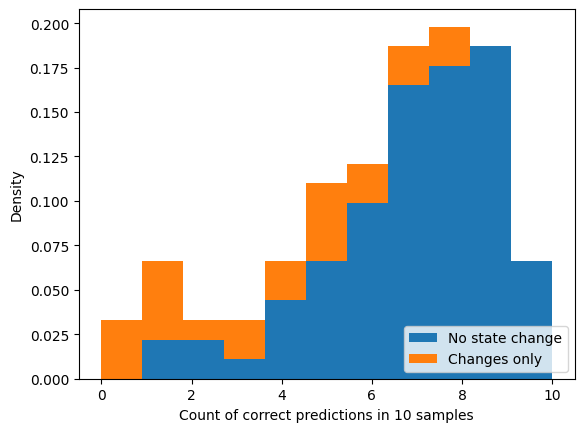

In [105]:
import matplotlib.pyplot as plt

correct_pred_counts = np.sum(state_pred_samples_correct[no_change_indices],axis=1)

correct_pred_counts_change_only = np.sum(state_pred_samples_correct[red_change_test_indices], axis=1)

# print(f"Correct prediction frequencies: {correct_pred_counts}")

plt.hist([correct_pred_counts,correct_pred_counts_change_only],num_eval_samples+1,density=True, stacked=True, label=["No state change", "Changes only"])
# plt.hist(correct_pred_counts_change_only,num_eval_samples+1,density=True)
plt.legend(loc="lower right")
plt.xlabel('Count of correct predictions in 10 samples')
plt.ylabel('Density')
plt.show()

In [115]:
from importlib import reload
import true_state_viewer
reload(true_state_viewer)
from true_state_viewer import display_tree_red_preds

In [111]:
display_tree_red_preds(state_pred_pair_tree_vis)

100


/usr/local/lib/python3.8/dist-packages/ipywidgets/widgets/widget.py:443: DeprecationWarning: Passing unrecognized arguments to super(IntSlider).__init__(name='Index').
object.__init__() takes exactly one argument (the instance to initialize)
This is deprecated in traitlets 4.2.This error will be raised in a future release of traitlets.
  super().__init__(**kwargs)
/usr/local/lib/python3.8/dist-packages/ipywidgets/widgets/widget.py:443: DeprecationWarning: Passing unrecognized arguments to super(HBox).__init__(overflow_x='auto', overflow='scroll').
object.__init__() takes exactly one argument (the instance to initialize)
This is deprecated in traitlets 4.2.This error will be raised in a future release of traitlets.
  super().__init__(**kwargs)


In [82]:
dist_of_item = train_df[(train_df[pre_cols + blue_cols] == test_df[pre_cols + blue_cols].iloc[2,:]).all(axis=1)][red_cols]
# for i, (test_x, test_y) in enumerate(test_dataset.take(1)):
#     print(test_x[0])
#     print(test_x[1])
#     print(test_y)

dist_of_item

uniques, counts = np.unique(dist_of_item.values, axis=0, return_counts=True)

print(uniques)

unique1 = tf.one_hot(tf.reshape(uniques[0],(-1,2)),depth=3)
gv = TrueStateTreeGraphViz(unique1)
gv.display()

/usr/local/lib/python3.8/dist-packages/ipykernel/ipkernel.py:281: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
# GET A HISTOGRAM WORKING
# add a function to display a histogram of the counts and the true state viz diagrams of the ith test df
# 

In [95]:
from IPython.display import display as display_func
import ipywidgets as widgets

/usr/local/lib/python3.8/dist-packages/ipykernel/ipkernel.py:281: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [142]:
def display_ith_train_histogram(test_index_i, preds):
    dist_of_item = train_df[(train_df[pre_cols + blue_cols] == test_df[pre_cols + blue_cols].iloc[test_index_i,:]).all(axis=1)][red_cols]
    uniques, counts = np.unique(dist_of_item.values, axis=0, return_counts=True)
    
    pred_uniques, pred_counts = np.unique(preds, axis=0, return_counts=True)
    density = list(counts/np.sum(counts))
    density.append(0)
    pred_density = pred_counts/np.sum(pred_counts)
    
    red_ts_ohs = []
    gv_imgs = []
    for red_ts in uniques:
        red_ts_oh = tf.one_hot(tf.reshape(red_ts,(-1,2)),depth=3)
        red_ts_ohs.append(red_ts_oh)
        gv = TrueStateTreeGraphViz(red_ts_oh)
        gv_imgs.append(widgets.Image(value = gv.g.pipe(), format='png', width=150))
    
    sidebyside_images = widgets.HBox(gv_imgs)
    
    pred_hist_list = []
    density_sum = 0
    for red_ts_ohs in red_ts_ohs:
        index=-1
        for i, pred in enumerate(pred_uniques):
            if np.all(red_ts_ohs == pred):
                index=i
                break
        if index >=0:
            pred_hist_list.append(pred_density[index])
            density_sum += pred_density[index]
        else:
            pred_hist_list.append(0)
            
    pred_hist_list.append(1.0-density_sum)
    

    x = [i for i in range(len(density))]

#     x_pos = [i for i, _ in enumerate(x)]
    x_pos = np.arange(len(x))
#     plt.bar(x_pos, density)
    plt.bar(x_pos - 0.2, density, 0.4, label = 'Dataset')
    plt.bar(x_pos + 0.2, pred_hist_list, 0.4, label = 'Predictions')
    plt.xlabel("Red TS transitions in training data")
    plt.ylabel("Count of predictions")
    plt.title(f"Histogram of Red behaviours for test data at index {test_index_i}")

    plt.xticks(x_pos, x)
    plt.legend()

    fig = plt.figure()

    plt.show(fig)
    display_func(sidebyside_images)


/usr/local/lib/python3.8/dist-packages/ipykernel/ipkernel.py:281: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


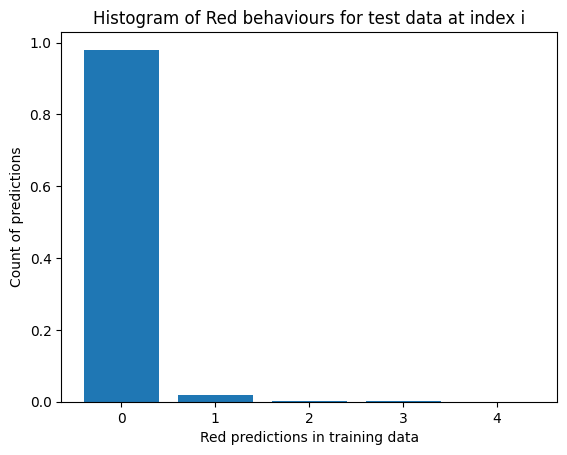

<Figure size 640x480 with 0 Axes>

In [97]:
display_ith_train_histogram(2)

In [ ]:
# run the eval code again but limit to 10 test samples with 100 samples each and no data shuffling
# (add a cap to the OG visualisation code)
# 

In [113]:
test_dataset_no_shuffle = (tf.data.Dataset.from_tensor_slices(((test_pre_df.values,test_blue_df.values),test_red_df.values)).batch(1))

totals_tuple, \
state_pred_pairs, \
state_pred_pair_tree_vis, \
state_pred_samples_correct, \
red_change_test_indices, \
no_change_indices = evaluate_on_test_dataset(test_dataset_no_shuffle, m2, test_dataset_cap=15, num_eval_samples=50)

accuracy = 455/750 = 0.6066666666666667, 
mean of squared diffs = 660.0/58500=0.011282051282051283
percentage wrong = (660.0/2)/(58500/3)=0.016923076923076923


In [116]:
display_tree_red_preds(state_pred_pair_tree_vis, pred_display_cap=15)

15


/usr/local/lib/python3.8/dist-packages/ipywidgets/widgets/widget.py:443: DeprecationWarning: Passing unrecognized arguments to super(IntSlider).__init__(name='Index').
object.__init__() takes exactly one argument (the instance to initialize)
This is deprecated in traitlets 4.2.This error will be raised in a future release of traitlets.
  super().__init__(**kwargs)
/usr/local/lib/python3.8/dist-packages/ipywidgets/widgets/widget.py:443: DeprecationWarning: Passing unrecognized arguments to super(HBox).__init__(overflow_x='auto', overflow='scroll').
object.__init__() takes exactly one argument (the instance to initialize)
This is deprecated in traitlets 4.2.This error will be raised in a future release of traitlets.
  super().__init__(**kwargs)


/usr/local/lib/python3.8/dist-packages/ipykernel/ipkernel.py:281: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


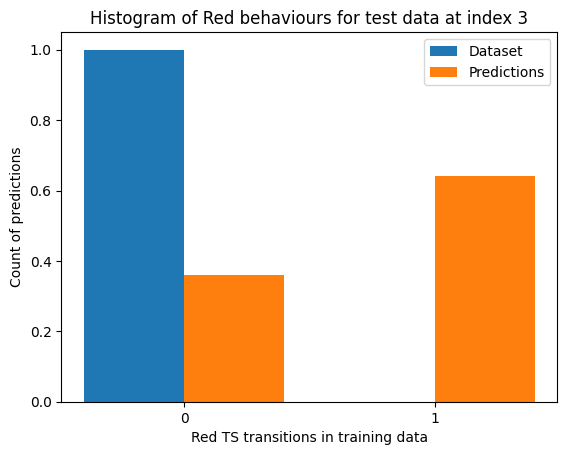

<Figure size 640x480 with 0 Axes>

In [151]:
idx = 3
display_ith_train_histogram(idx,state_pred_pairs[idx][1])

In [ ]:
# add a funtion to get predictions from the state pred pairs and create the same unique counts
# add a function to match and reorder the the unique counts to the test data unique count elements (adding column/s for incorrect ones)
# add that plot to the histogram
# 
# add functionality to flick through the indexes (or add this to the existing functionality)
# 